<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19-SPOT/vecicle_spot_position_VGG19_epoch_10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/10
65/65 [==============================] - 1011s 16s/step - loss: 3.4831 - accuracy: 0.3714 - val_loss: 4.5517 - val_accuracy: 0.3482
Epoch 2/10
65/65 [==============================] - 1005s 15s/step - loss: 2.6576 - accuracy: 0.3839 - val_loss: 4.1614 - val_accuracy: 0.3705
Epoch 3/10
65/65 [==============================] - 1000s 15s/step - loss: 2.5317 - accuracy: 0.3985 - val_loss: 3.8263 - val_accuracy: 0.4018
Epoch 4/10
65/65 [==============================] - 997s 15s/step - loss: 2.3596 - accuracy: 0.4226 - val_loss: 3.4441 - val_accuracy: 0.4152
Epoch 5/10
65/65 [==============================] - 998s 15s/step - loss: 2.2586 - accuracy: 0.4458 - val_loss: 3.1876 - val_accuracy: 0.4286
Epoch 6/10
65/65 [==============================] - 967s 15s/step - loss: 2.0416 - accuracy: 0.451

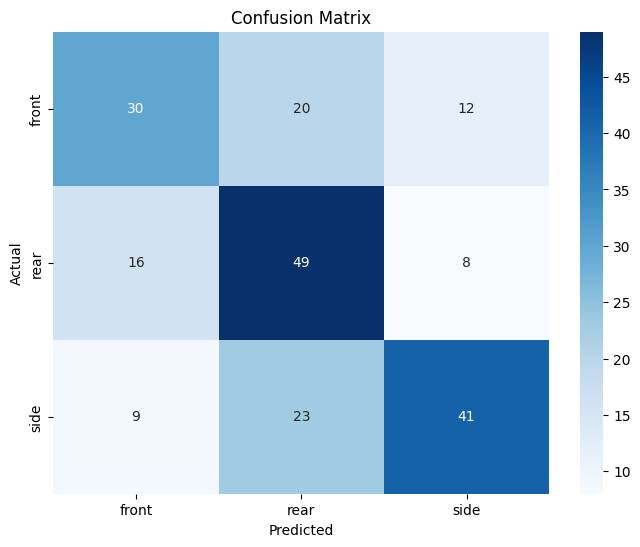

Test loss: 1.5836
Test accuracy: 56.73
Train loss: 1.7557
Train accuracy: 51.25
Recall: 0.57
Precision: 0.58
F1-score: 0.57


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/dataset for spot/train'
val_dir = '/content/drive/MyDrive/dataset for spot/validation'
test_dir = '/content/drive/MyDrive/dataset for spot/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG19_epoch_10_dataset.h5')
